# CREDENTIAL RISK ASSESSMENT




## LOADING DEPENDENCY

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

## LOADING FILES AND EXPLORATION

In [10]:
credit_data = pd.read_csv('/content/credit_risk_dataset.csv')

In [11]:
credit_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## EDA PHASE BEGINS

In [12]:
credit_data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [13]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


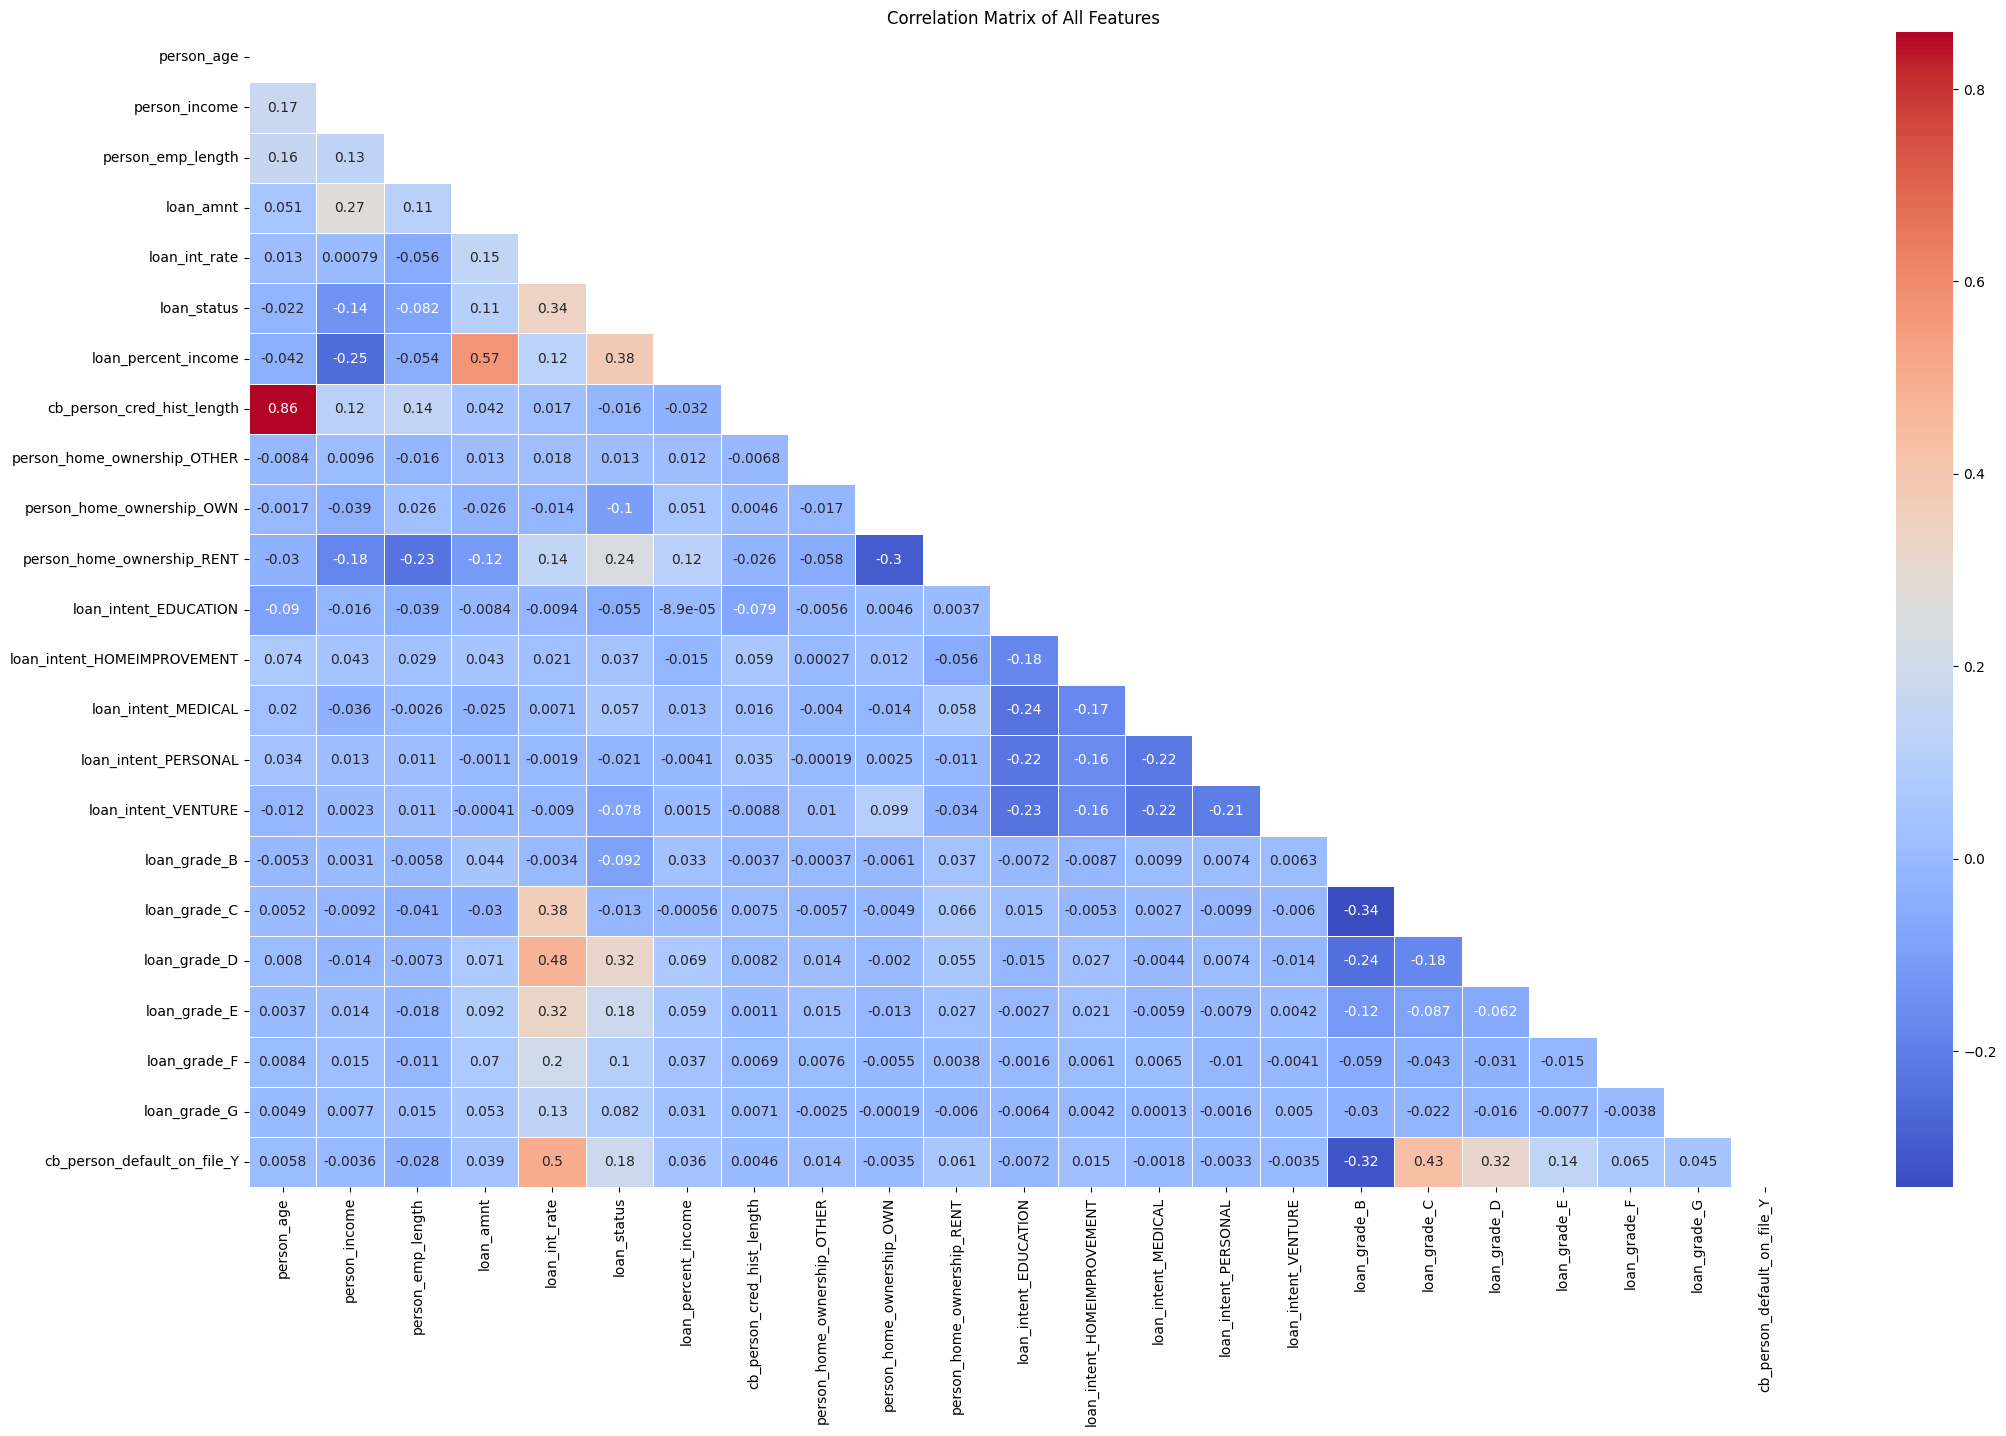

In [14]:
credit_data_encoded = pd.get_dummies(credit_data, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)

correlation_matrix = credit_data_encoded.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(25,15))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.title('Correlation Matrix of All Features')
plt.show()

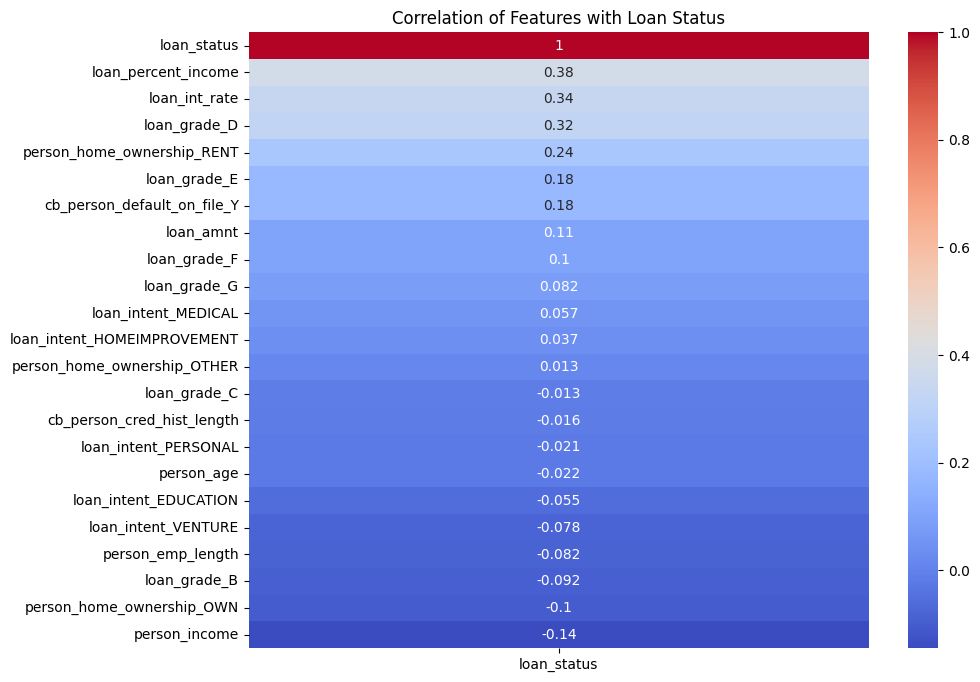

In [15]:
credit_data_encoded = pd.get_dummies(credit_data, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)

correlation_matrix = credit_data_encoded.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix[['loan_status']].sort_values(by='loan_status', ascending=False), annot=True, cmap='coolwarm')

plt.title('Correlation of Features with Loan Status')
plt.show()

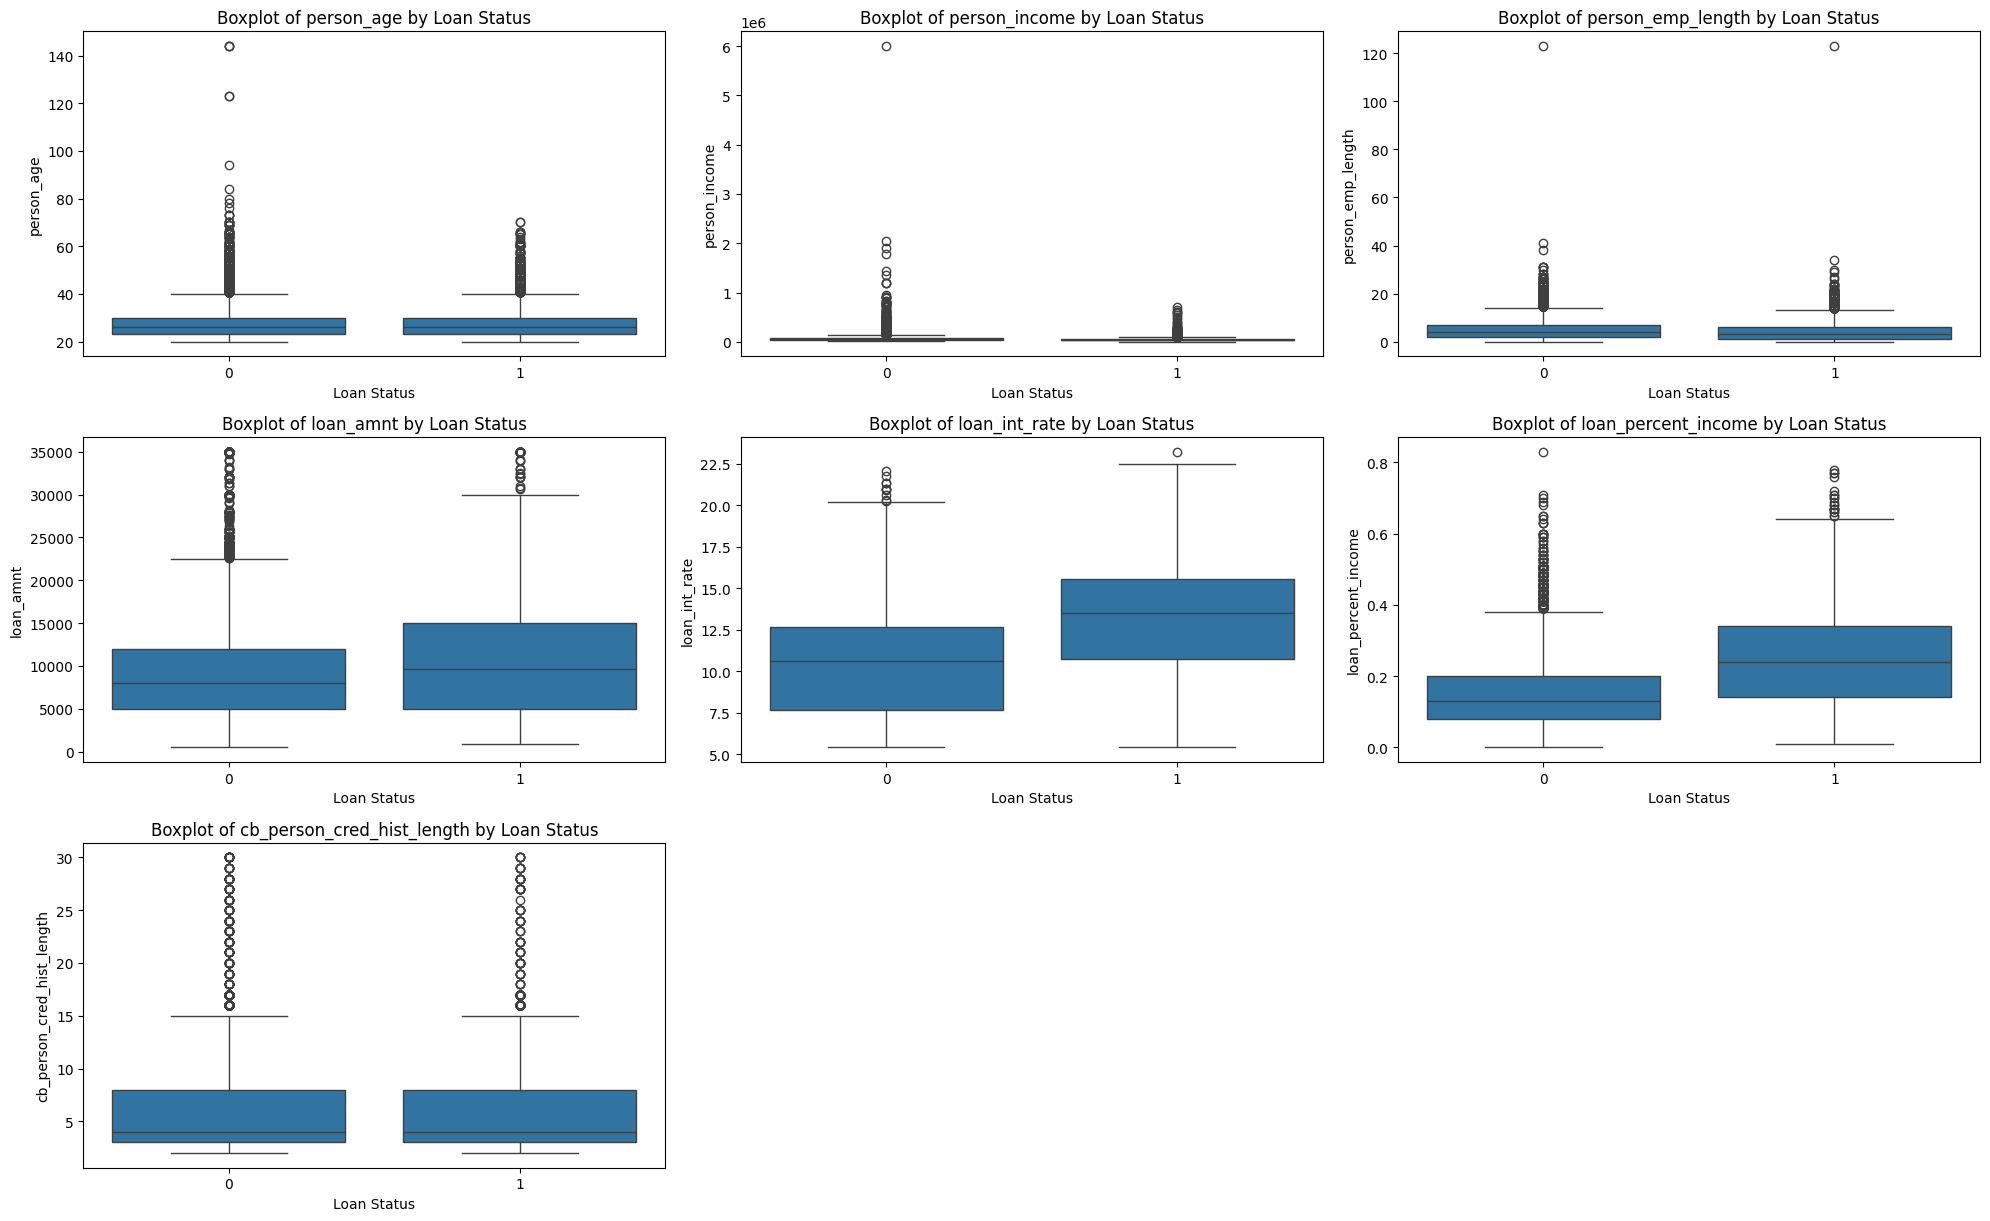

In [16]:
columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length']

plt.figure(figsize=(20,20))

for i, column in enumerate(columns, 1):
    plt.subplot(5, 3, i)  # Adjust the grid size if needed
    sns.boxplot(x='loan_status', y=column, data=credit_data)
    plt.title(f'Boxplot of {column} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [17]:
def remove_rows_based_on_iqr(df, include_cols, iqr_threshold):
    df_cleaned = df.copy()

    for col in include_cols:
        if col in df_cleaned.columns and df_cleaned[col].dtype in ['int64', 'float64']:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - iqr_threshold * IQR
            upper_bound = Q3 + iqr_threshold * IQR

            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned


include_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
credit_df_cleaned = remove_rows_based_on_iqr(credit_data, include_cols=include_columns, iqr_threshold=2.5)
credit_df_cleaned

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32290,37,90000,MORTGAGE,11.0,DEBTCONSOLIDATION,A,4000,6.62,0,0.04,N,15
32293,38,110000,MORTGAGE,5.0,MEDICAL,B,16000,11.99,0,0.15,N,13
32294,36,92000,MORTGAGE,18.0,DEBTCONSOLIDATION,A,4000,7.29,0,0.04,N,13
32295,42,101000,MORTGAGE,6.0,DEBTCONSOLIDATION,F,25000,16.15,1,0.25,Y,14


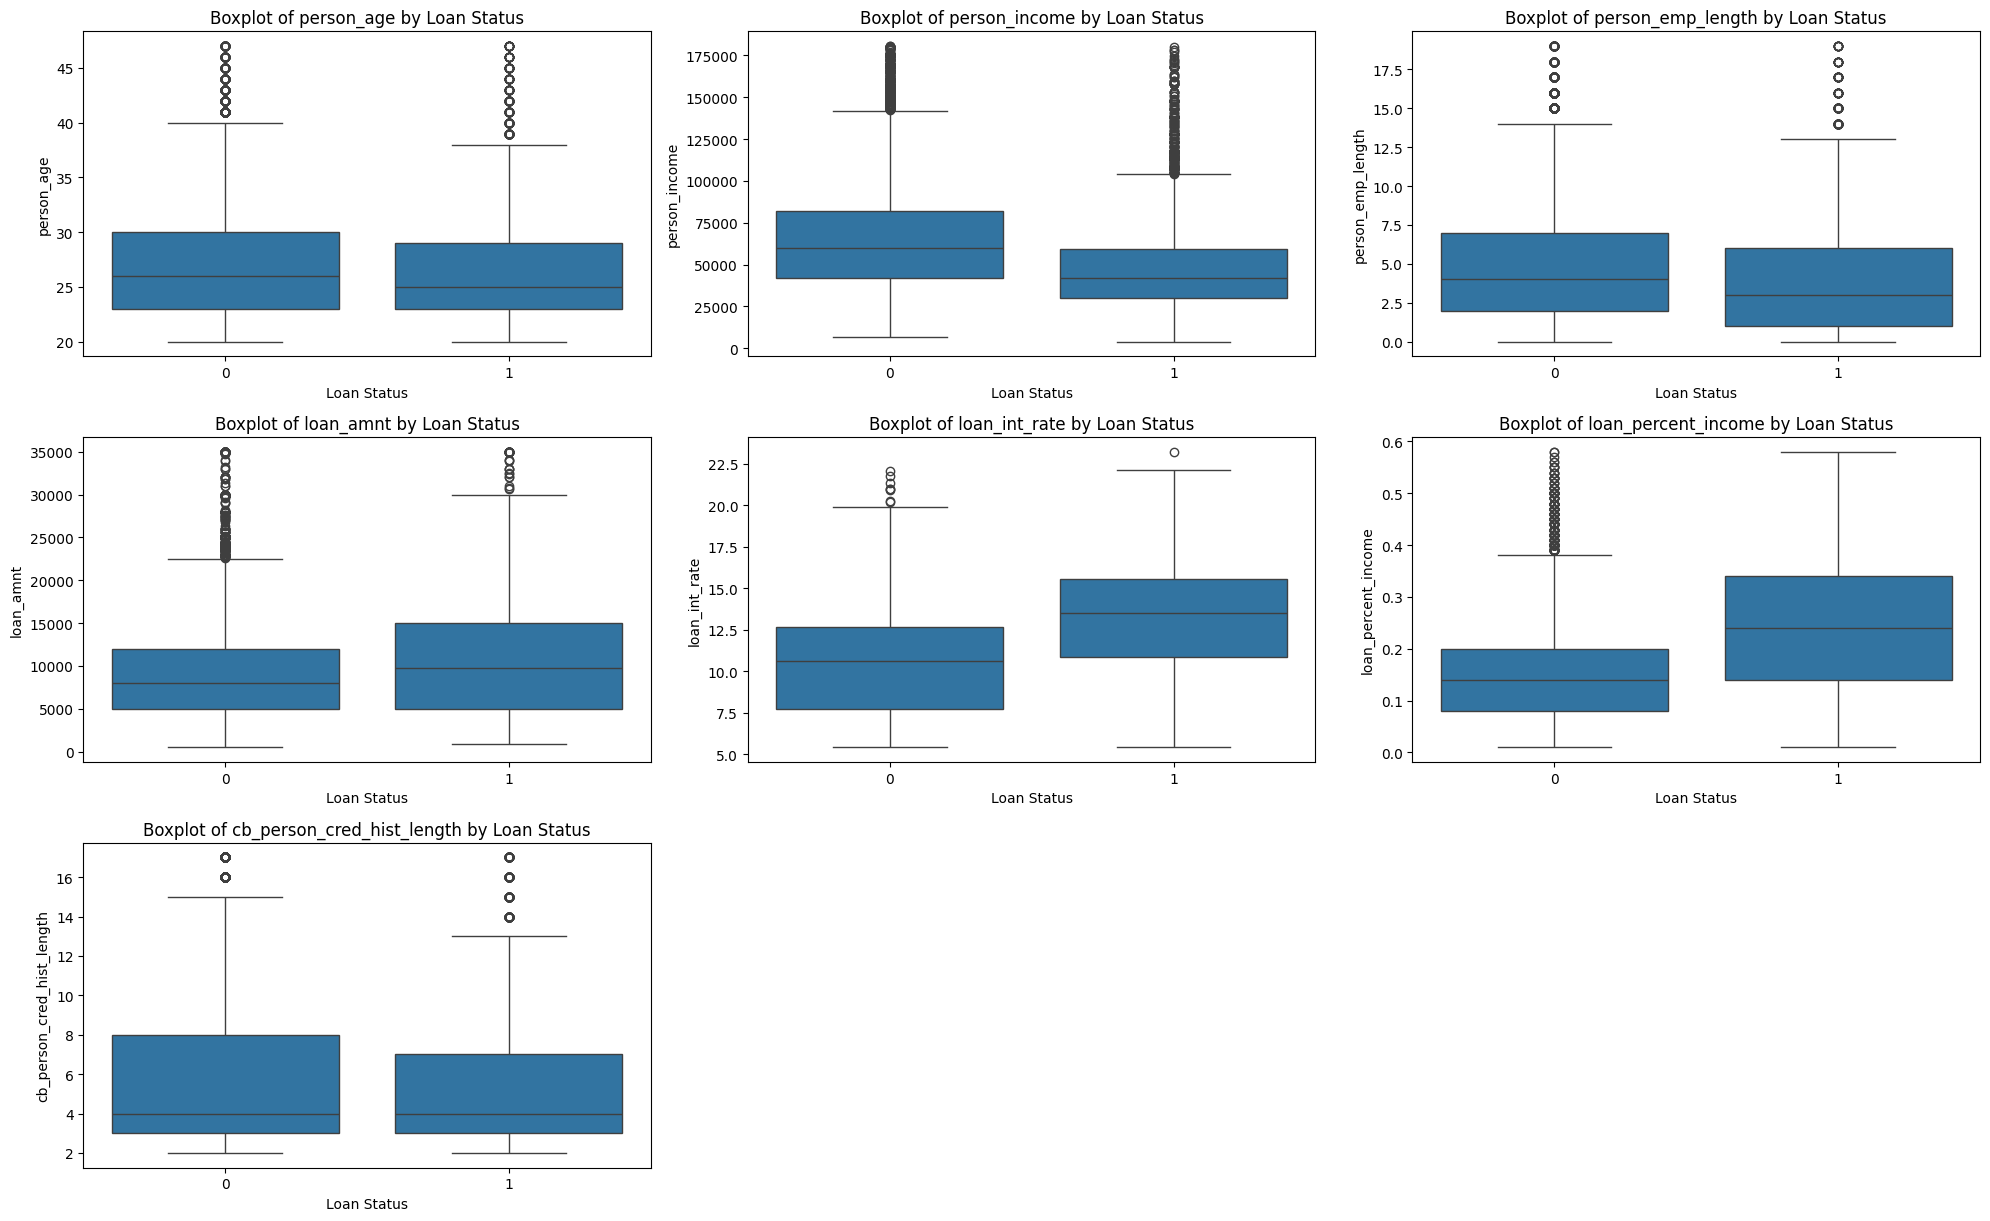

In [ ]:
columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length']

plt.figure(figsize=(20,20))

for i, column in enumerate(columns, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x='loan_status', y=column, data=credit_df_cleaned)
    plt.title(f'Boxplot of {column} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

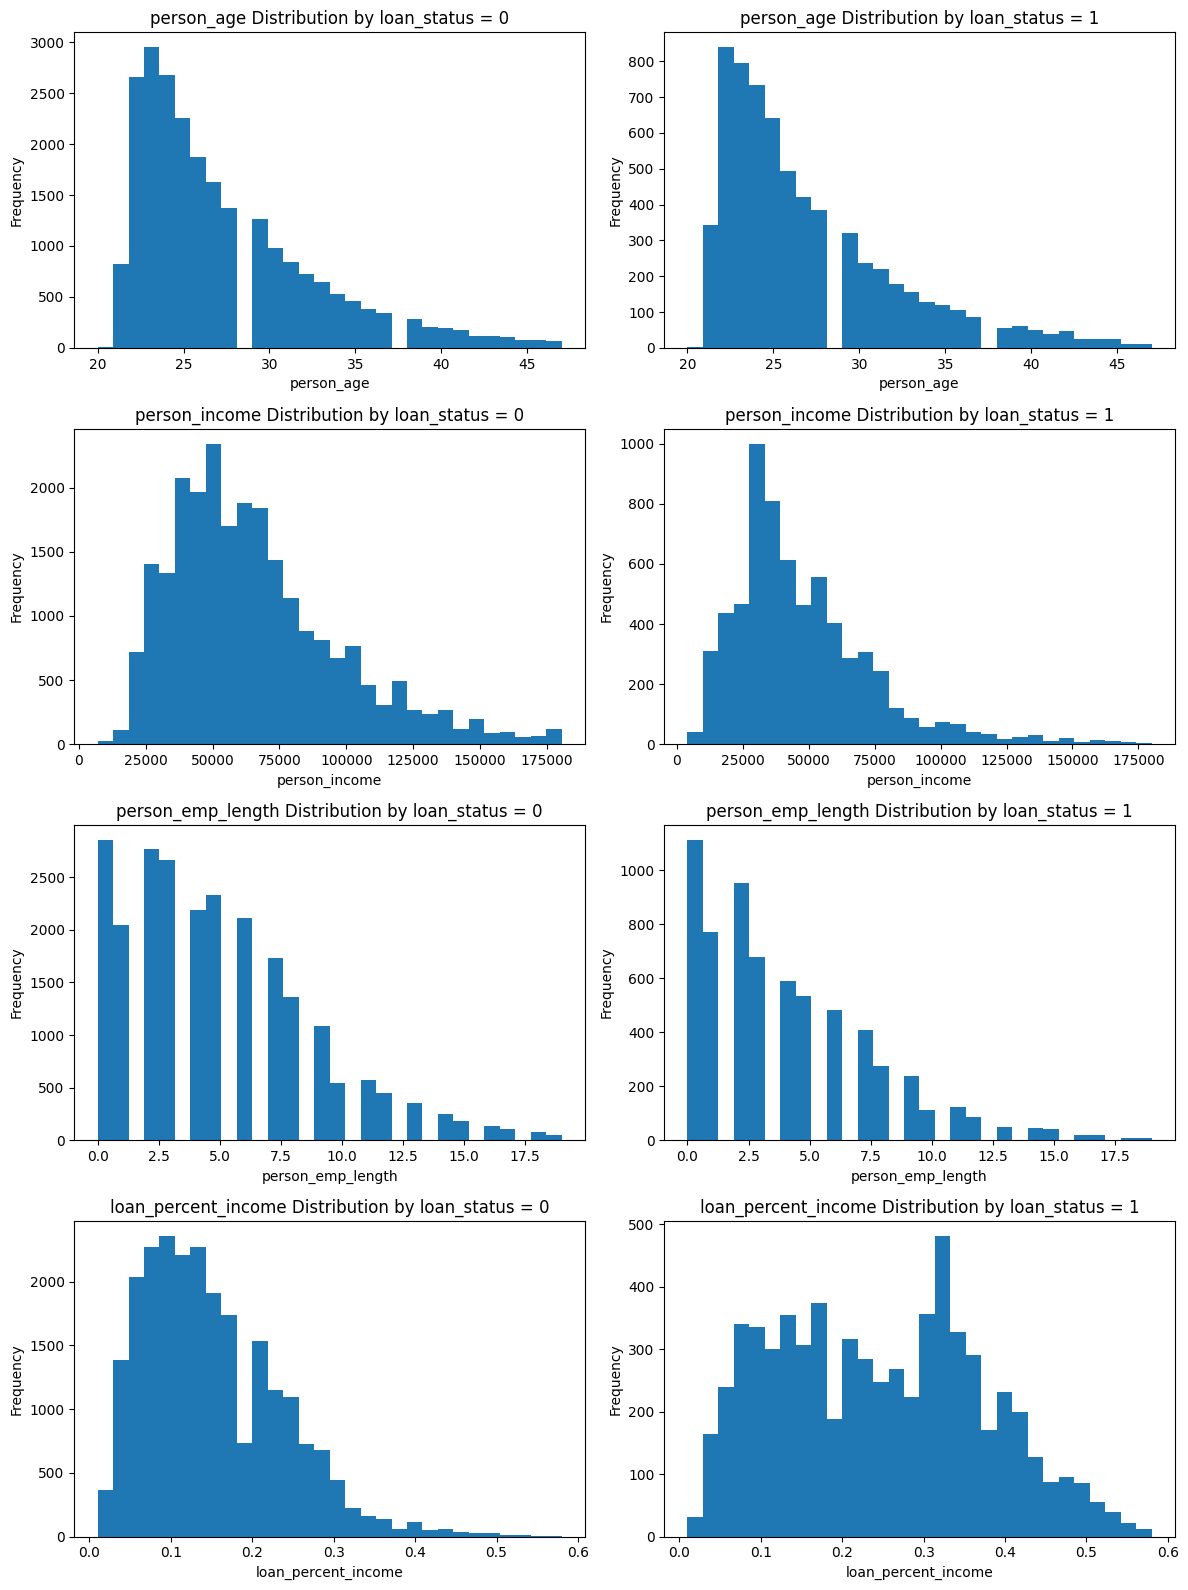

In [ ]:
def plot_histograms(df, target_col, feature_cols):
    num_features = len(feature_cols)

    # Create a subplot for each feature
    fig, axes = plt.subplots(num_features, 2, figsize=(12, num_features * 4))

    if num_features == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, col in enumerate(feature_cols):
        # Plot histogram for target == 0
        df[df[target_col] == 0][col].plot(kind='hist', ax=axes[i][0], title=f'{col} Distribution by {target_col} = 0', bins=30)
        axes[i][0].set_xlabel(col)

        # Plot histogram for target == 1
        df[df[target_col] == 1][col].plot(kind='hist', ax=axes[i][1], title=f'{col} Distribution by {target_col} = 1', bins=30)
        axes[i][1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

# Example usage
include_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
plot_histograms(credit_df_cleaned, 'loan_status', include_columns)

In [ ]:
def apply_log_transformation(df, include_cols):
    df_transformed = df.copy()

    for col in include_cols:
        if col in df_transformed.columns and df_transformed[col].dtype in ['int64', 'float64']:
            df_transformed[col] = df_transformed[col].apply(lambda x: np.log(x) if x > 0 else np.nan)

    return df_transformed

# Example usage
include_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
credit_df_transformed = apply_log_transformation(credit_data, include_cols=include_columns)
credit_df_transformed

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,3.091042,10.985293,RENT,4.812184,PERSONAL,D,35000,16.02,1,-0.527633,Y,3
1,3.044522,9.169518,OWN,1.609438,EDUCATION,B,1000,11.14,0,-2.302585,N,2
2,3.218876,9.169518,MORTGAGE,0.000000,MEDICAL,C,5500,12.87,1,-0.562119,N,3
3,3.135494,11.089805,RENT,1.386294,MEDICAL,C,35000,15.23,1,-0.634878,N,2
4,3.178054,10.904119,RENT,2.079442,MEDICAL,C,35000,14.27,1,-0.597837,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,4.043051,10.878047,MORTGAGE,0.000000,PERSONAL,C,5800,13.16,0,-2.207275,N,30
32577,3.988984,11.695247,MORTGAGE,1.386294,PERSONAL,A,17625,7.49,0,-1.897120,N,19
32578,4.174387,11.238489,RENT,1.098612,HOMEIMPROVEMENT,B,35000,10.99,1,-0.776529,N,28
32579,4.025352,11.918391,MORTGAGE,1.609438,PERSONAL,B,15000,11.48,0,-2.302585,N,26


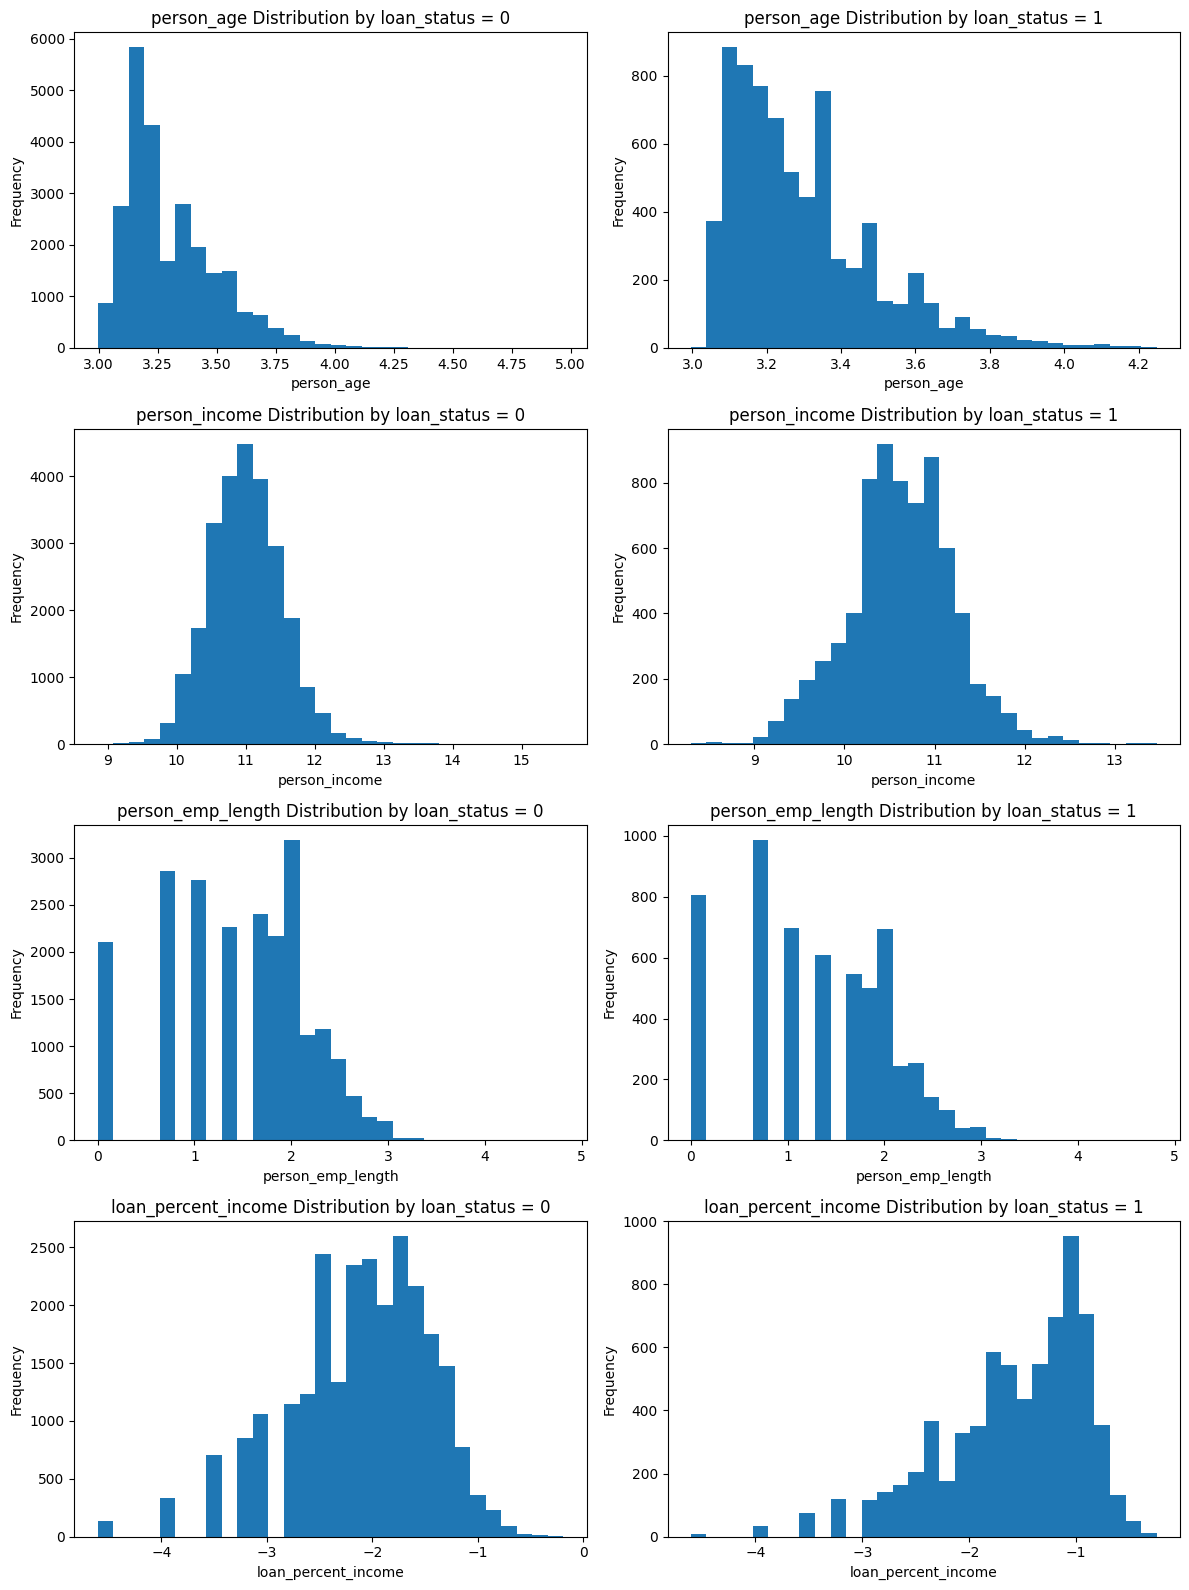

In [ ]:
def plot_histograms(df, target_col, feature_cols):
    num_features = len(feature_cols)

    # Create a subplot for each feature
    fig, axes = plt.subplots(num_features, 2, figsize=(12, num_features * 4))

    if num_features == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, col in enumerate(feature_cols):
        # Plot histogram for target == 0
        df[df[target_col] == 0][col].plot(kind='hist', ax=axes[i][0], title=f'{col} Distribution by {target_col} = 0', bins=30)
        axes[i][0].set_xlabel(col)

        # Plot histogram for target == 1
        df[df[target_col] == 1][col].plot(kind='hist', ax=axes[i][1], title=f'{col} Distribution by {target_col} = 1', bins=30)
        axes[i][1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

# Example usage
include_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
plot_histograms(credit_df_transformed, 'loan_status', include_columns)

In [ ]:
credit_df_cleaned.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

## TESTING SOME HYPOTHESIS FOR EDA

In [ ]:
credit_df_cleaned.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [ ]:
len(credit_df_cleaned[credit_df_cleaned['loan_status'] == 1]),len(credit_df_cleaned[credit_df_cleaned['loan_status'] == 0])

(6559, 23850)

### HYPOTHESIS FORMULATION AND STUDY

#### Hypothesis 1: Older applicants are less likely to default on their loans compared to younger applicants


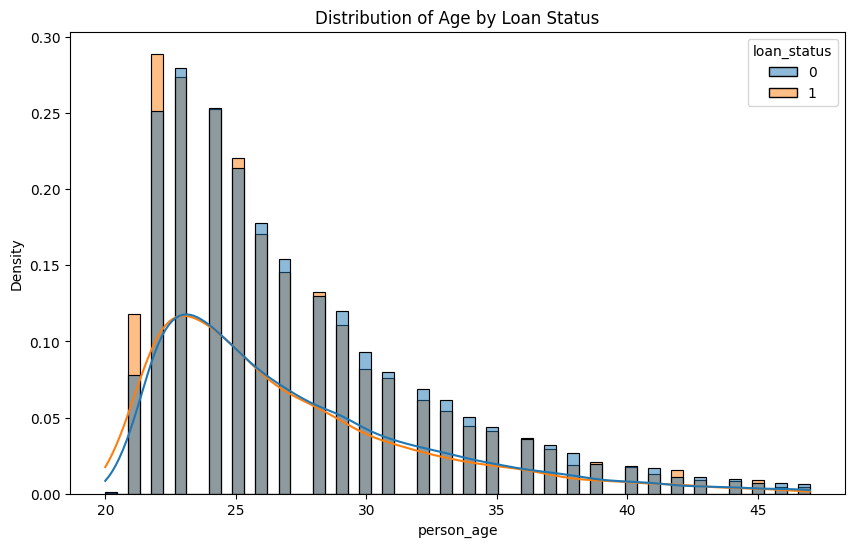

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=credit_df_cleaned, x='person_age', hue='loan_status', kde=True, stat="density", common_norm=False)
plt.title('Distribution of Age by Loan Status')
plt.show()

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['person_age'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between Age and loan default status.")
else:
    print("There is no statistically significant relationship between Age and loan default status.")

Chi-square statistic: 89.22678631664849
P-value: 1.4053063610029427e-08
Degrees of freedom: 27
There is a statistically significant relationship between Age and loan default status.


Interpretation of Hypothesis:
This graph supports the hypothesis that younger borrowers are more likely to default on their loans compared to older borrowers. The density of defaults (orange) is notably higher for younger individuals, particularly around age 20. As borrowers age, the likelihood of default decreases, as indicated by the shrinking orange areas and the increasing density of non-defaults.

#### Hypothesis 2: Applicants who own their homes are less likely to default on their loans


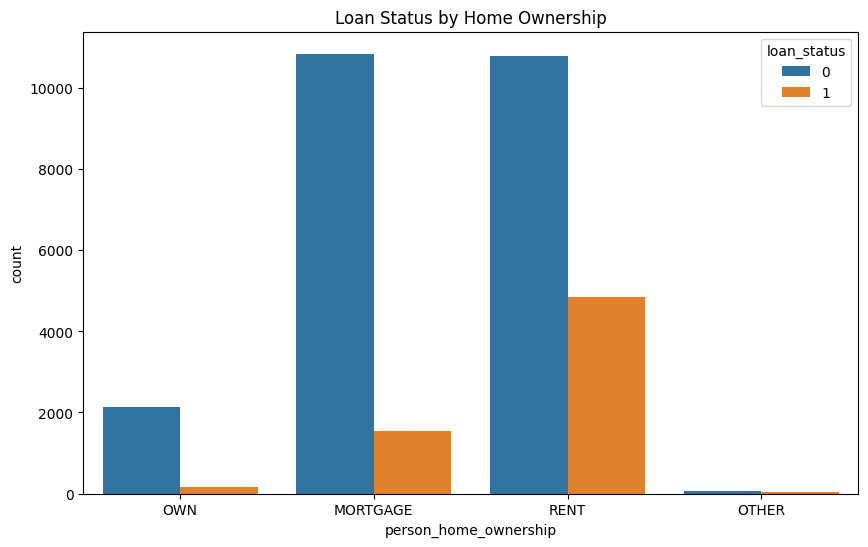

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=credit_df_cleaned, x='person_home_ownership', hue='loan_status')
plt.title('Loan Status by Home Ownership')
plt.show()

In [ ]:
proportions = credit_df_cleaned.groupby('person_home_ownership')['loan_status'].mean()
proportions

person_home_ownership
MORTGAGE    0.123819
OTHER       0.330000
OWN         0.068261
RENT        0.309445
Name: loan_status, dtype: float64

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['person_home_ownership'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between home ownership and loan default status.")
else:
    print("There is no statistically significant relationship between home ownership and loan default status.")

Chi-square statistic: 1732.9765877707177
P-value: 0.0
Degrees of freedom: 3
There is a statistically significant relationship between home ownership and loan default status.


#### Hypothesis 3: Borrowers with longer employment lengths are less likely to default on their loans


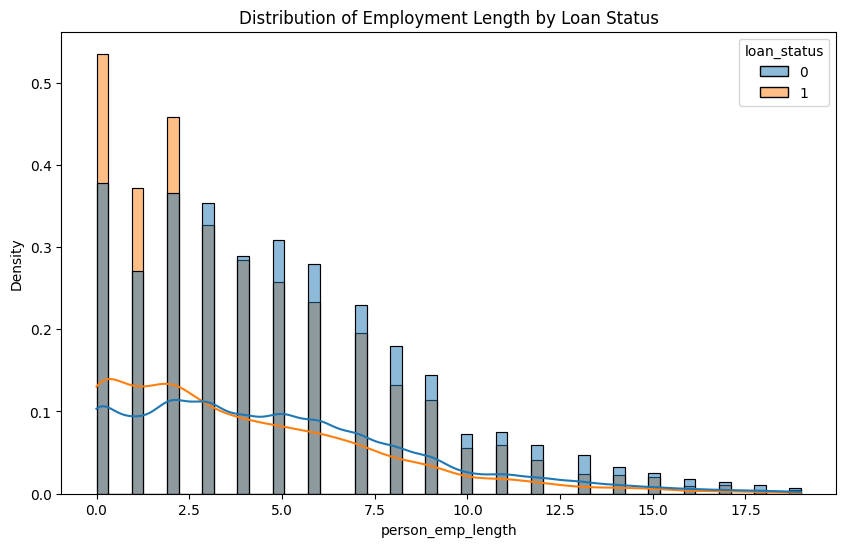

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=credit_df_cleaned, x='person_emp_length', hue='loan_status', kde=True, stat="density", common_norm=False)
plt.title('Distribution of Employment Length by Loan Status')
plt.show()

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['person_emp_length'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between employement and loan default status.")
else:
    print("There is no statistically significant relationship between employement and loan default status.")

Chi-square statistic: 330.81772305767447
P-value: 9.284191888919078e-59
Degrees of freedom: 19
There is a statistically significant relationship between employement and loan default status.


#### Hypothesis 4: The intent of the loan affects the likelihood of default

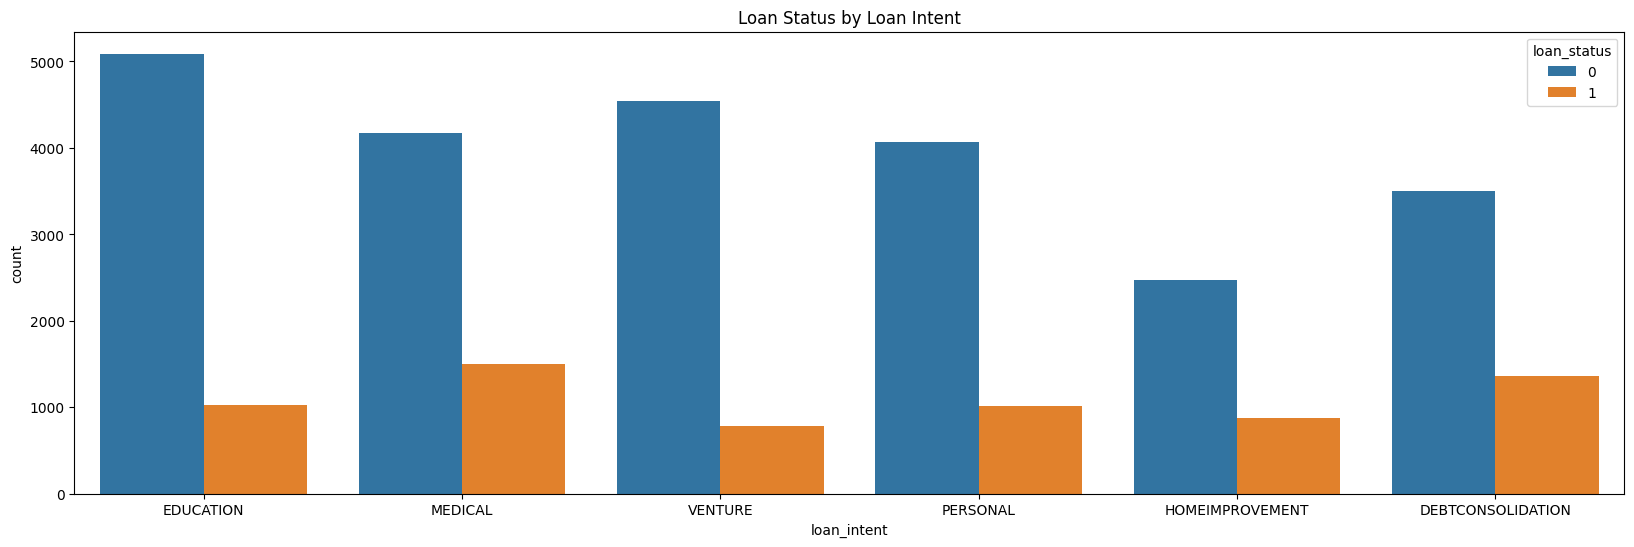

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(data=credit_df_cleaned, x='loan_intent', hue='loan_status')
plt.title('Loan Status by Loan Intent')
plt.show()

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['loan_intent'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between Loan Intent and loan default status.")
else:
    print("There is no statistically significant relationship between Loan Intent and loan default status.")

Chi-square statistic: 473.00450276889666
P-value: 5.348666821891793e-100
Degrees of freedom: 5
There is a statistically significant relationship between Loan Intent and loan default status.


In [ ]:
credit_df_cleaned.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

#### Hypothesis 5: The personal income wealth affects your chances of getting a loan?

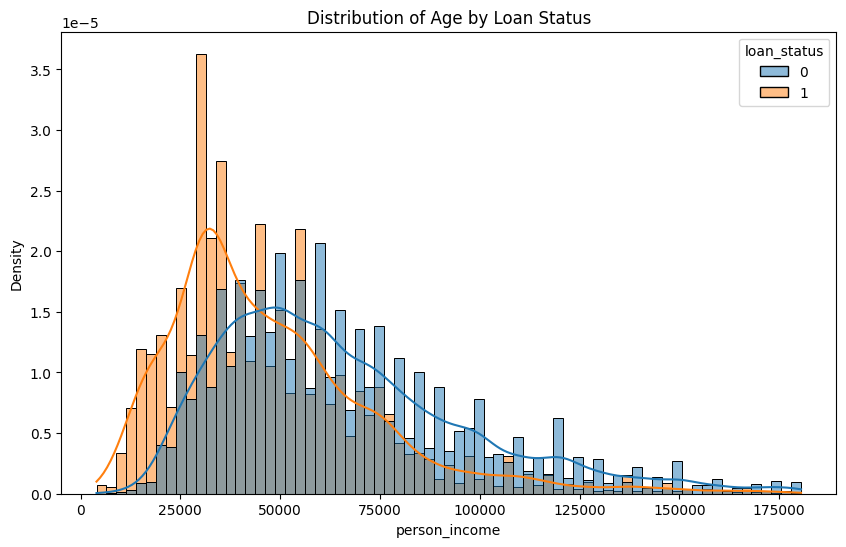

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=credit_df_cleaned, x='person_income', hue='loan_status', kde=True, stat="density", common_norm=False)
plt.title('Income as per by Loan Status')
plt.show()

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['person_income'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between Personal Income and loan default status.")
else:
    print("There is no statistically significant relationship between Personal Income and loan default status.")

Chi-square statistic: 10872.371580721127
P-value: 0.0
Degrees of freedom: 3866
There is a statistically significant relationship between Personal Income and loan default status.


#### MODEL SELECTION

In [ ]:
credit_df_cleaned

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32290,37,90000,MORTGAGE,11.0,DEBTCONSOLIDATION,A,4000,6.62,0,0.04,N,15
32293,38,110000,MORTGAGE,5.0,MEDICAL,B,16000,11.99,0,0.15,N,13
32294,36,92000,MORTGAGE,18.0,DEBTCONSOLIDATION,A,4000,7.29,0,0.04,N,13
32295,42,101000,MORTGAGE,6.0,DEBTCONSOLIDATION,F,25000,16.15,1,0.25,Y,14


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
# !pip install --upgrade xgboost scikit-learn imbalanced-learn
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [18]:
# Define categorical and numerical features
categorical_features = [col for col in credit_df_cleaned.columns if credit_df_cleaned[col].dtype == 'object']
numerical_features = [col for col in credit_df_cleaned.columns if credit_df_cleaned[col].dtype in ['int64', 'float64']]
numerical_features.remove('loan_status')  # Assuming 'target' is the label

In [19]:
# Preprocessing pipeline
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [20]:
# Train-test split
X = credit_df_cleaned.drop(columns=['loan_status'])
y = credit_df_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [22]:
# Feature Selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [23]:
# Create models with feature selection included in each pipeline
models = {
    'Logistic Regression': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('classifier', RandomForestClassifier())
    ]),
    'Gradient Boosting': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('classifier', GradientBoostingClassifier())
    ]),
    'XGBoost': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('classifier', XGBClassifier(eval_metric='logloss'))
    ])
}

In [24]:
# X_train_resampled.shape

In [25]:
#Tracking best model
best_model = None
best_model_name = None
best_auc = 0

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_transformed)
    y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Model: {name}")
    print("Accuracy:", accuracy)
    print("ROC AUC:", auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

    # Track best model based on AUC
    if auc > best_auc:
        best_auc = auc
        best_model = model
        best_model_name = name

print(f"Best model: {best_model_name} with AUC: {best_auc}")

# Save the best model (including preprocessing)
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('best_model', best_model)
])

Model: Logistic Regression
Accuracy: 0.798750411048997
ROC AUC: 0.8650534335532034
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      4770
           1       0.52      0.78      0.63      1312

    accuracy                           0.80      6082
   macro avg       0.73      0.79      0.74      6082
weighted avg       0.84      0.80      0.81      6082

--------------------------------------------------
Model: Random Forest
Accuracy: 0.887865833607366
ROC AUC: 0.9086891042849107
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4770
           1       0.74      0.74      0.74      1312

    accuracy                           0.89      6082
   macro avg       0.83      0.83      0.83      6082
weighted avg       0.89      0.89      0.89      6082

--------------------------------------------------
Model: Gradient Boosting
Accuracy: 0

In [ ]:
joblib.dump(full_pipeline, 'best_credit_risk_model.pkl')

['best_credit_risk_model.pkl']

In [ ]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy=...
                                                grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                multi_strategy=None,
                                                n_estimators=None, n_jobs=None,
                                                num_parallel_tree=None,
                                                random_state=None, ...))]))])

#### **Hyperparameter Tuning**

In [26]:
# Define hyperparameter search spaces for each model
param_distributions = {
    'Logistic Regression': {
        'selector__k': randint(5, min(30, X_train_transformed.shape[1])),
        'classifier__C': uniform(0.01, 10),
        'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'classifier__class_weight': ['balanced', None]
    },
    'Random Forest': {
        'selector__k': randint(5, min(30, X_train_transformed.shape[1])),
        'classifier__n_estimators': randint(50, 500),
        'classifier__max_depth': randint(3, 20),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 10),
        'classifier__max_features': ['sqrt', 'log2', None],
        'classifier__class_weight': ['balanced', 'balanced_subsample', None]
    },
    'Gradient Boosting': {
        'selector__k': randint(5, min(30, X_train_transformed.shape[1])),
        'classifier__n_estimators': randint(50, 500),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__max_depth': randint(3, 10),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 10),
        'classifier__subsample': uniform(0.5, 0.5),
        'classifier__max_features': ['sqrt', 'log2', None]
    },
    'XGBoost': {
        'selector__k': randint(5, min(30, X_train_transformed.shape[1])),
        'classifier__n_estimators': randint(50, 500),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__max_depth': randint(3, 10),
        'classifier__min_child_weight': randint(1, 10),
        'classifier__subsample': uniform(0.5, 0.5),
        'classifier__colsample_bytree': uniform(0.5, 0.5),
        'classifier__gamma': uniform(0, 1),
        'classifier__reg_alpha': uniform(0, 1),
        'classifier__reg_lambda': uniform(0, 1)
    }
}

# Create model pipelines with feature selection
base_models = {
    'Logistic Regression': Pipeline([
        ('selector', SelectKBest(score_func=f_classif)),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('selector', SelectKBest(score_func=f_classif)),
        ('classifier', RandomForestClassifier())
    ]),
    'Gradient Boosting': Pipeline([
        ('selector', SelectKBest(score_func=f_classif)),
        ('classifier', GradientBoostingClassifier())
    ]),
    'XGBoost': Pipeline([
        ('selector', SelectKBest(score_func=f_classif)),
        ('classifier', XGBClassifier(eval_metric='logloss'))
    ])
}

# Tracking best model
best_model = None
best_model_name = None
best_auc = 0
tuned_models = {}

# Set up cross-validation parameters
cv_folds = 5
n_iter = 20  # Number of parameter settings sampled

print("Starting hyperparameter tuning...")

for name, model in base_models.items():
    print(f"\nTuning {name}...")

    # Set up randomized search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=n_iter,
        cv=cv_folds,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    # Fit the randomized search
    random_search.fit(X_train_resampled, y_train_resampled)

    # Get the best model
    tuned_model = random_search.best_estimator_
    tuned_models[name] = tuned_model

    # Evaluate on test set
    y_pred = tuned_model.predict(X_test_transformed)
    y_pred_proba = tuned_model.predict_proba(X_test_transformed)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\nBest parameters for {name}:")
    print(random_search.best_params_)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 80)

    # Track best model based on AUC
    if auc > best_auc:
        best_auc = auc
        best_model = tuned_model
        best_model_name = name

print(f"\nBest model after tuning: {best_model_name} with AUC: {best_auc:.4f}")

Starting hyperparameter tuning...

Tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l


Best parameters for Logistic Regression:
{'classifier__C': np.float64(9.709098521619943), 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'selector__k': 25}
Accuracy: 0.8114
ROC AUC: 0.8776
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4770
           1       0.54      0.79      0.64      1312

    accuracy                           0.81      6082
   macro avg       0.74      0.80      0.76      6082
weighted avg       0.85      0.81      0.82      6082

--------------------------------------------------------------------------------

Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters for Random Forest:
{'classifier__class_weight': None, 'classifier__max_depth': 17, 'classifier__max_features': None, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 171, 'select

In [30]:
if best_model is not None:
    print(f"\nCalculating final metrics for the best model: {best_model_name}")

    # Predict using the final best model on the test set
    y_pred_best = best_model.predict(X_test_transformed)
    y_pred_proba_best = best_model.predict_proba(X_test_transformed)[:, 1]

    # Calculate the required metrics
    final_accuracy = accuracy_score(y_test, y_pred_best)
    final_roc_auc = roc_auc_score(y_test, y_pred_proba_best)
    # Calculate precision for the positive class (usually 1)
    # Use zero_division=0 to handle cases where precision might be undefined (no positive predictions)
    final_precision = precision_score(y_test, y_pred_best, zero_division=0)

    print(f"Final Accuracy: {final_accuracy:.4f}")
    print(f"Final ROC AUC: {final_roc_auc:.4f}")
    print(f"Final Precision: {final_precision:.4f}") # Precision for the positive class
    print("\nFinal Classification Report:")
    # Calculate and print the full report for detailed view
    print(classification_report(y_test, y_pred_best))

    # Create the metrics dictionary for saving
    # Ensure the keys match what your Streamlit app expects
    model_metrics_to_save = {
        "accuracy": final_accuracy,
        "roc_auc": final_roc_auc,
        "precision": final_precision
        # You could add other metrics from classification_report if needed
        # e.g., from sklearn.metrics import recall_score, f1_score
        # "recall": recall_score(y_test, y_pred_best, zero_division=0),
        # "f1_score": f1_score(y_test, y_pred_best, zero_division=0)
    }

    # Define the filename
    metrics_filename = 'model_metrics.pkl'

    # Save the metrics dictionary using joblib
    try:
        joblib.dump(model_metrics_to_save, metrics_filename)
        print(f"\nSuccessfully saved final model metrics to {metrics_filename}")
    except Exception as e:
        print(f"\nError saving model metrics to {metrics_filename}: {e}")

    # --- ALSO SAVE THE BEST MODEL ITSELF ---
    # Use the filename your Streamlit app expects
    model_filename = 'credit_risk_best_tuned_model.pkl'
    # Create the final, combined pipeline
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Step 1: Applies OHE, scaling etc.
        ('best_model', best_model)       # Step 2: Takes preprocessed data, applies SelectKBest, then classifies
    ])
    try:
        joblib.dump(full_pipeline, model_filename)
        print(f"Successfully saved the best model ({best_model_name}) to {model_filename}")
    except Exception as e:
        print(f"Error saving the best model to {model_filename}: {e}")

else:
    print("\nNo best model was found. Metrics and model not saved.")

# --- END: Added code ---


Calculating final metrics for the best model: XGBoost
Final Accuracy: 0.9365
Final ROC AUC: 0.9460
Final Precision: 0.9461

Final Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4770
           1       0.95      0.75      0.84      1312

    accuracy                           0.94      6082
   macro avg       0.94      0.87      0.90      6082
weighted avg       0.94      0.94      0.93      6082


Successfully saved final model metrics to model_metrics.pkl
Successfully saved the best model (XGBoost) to credit_risk_best_tuned_model.pkl


In [31]:
# # Save the best model (including preprocessing)
# full_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('best_model', best_model)
# ])

# # Optional: Save the model to disk
# import joblib
# joblib.dump(full_pipeline, 'credit_risk_best_tuned_model.pkl')